# Toy Hamiltonian in 1d, 1 particle

This simple example explores the NICE bijector with a shift function that 1) is the derivative of a generating function modeled as MLP; 2) is an MLP. This is done since in higher dimensions we have to model the shift function as derivative of a generating function that is a neural network and in the present simple setup we can build some intuition on what neural network we should use.

Also, we compare the system flow computed using symplectic flow and that using integrators of Hamilton's equation, finding **good agreement**, which validates the symplectic flow approach as an alternative, time-independent, method to solve classical mechanics.

## Settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
from hamiltonians import toy_hamiltonian
from models import NICE, SymplecticExchange, SqueezeAndShift, Chain, MLP
from utils import visualize_chain_bijector_1d, compute_loss, compute_gradients, apply_gradients

In [3]:
tf.enable_eager_execution()

In [4]:
tf.set_random_seed(0)

In [5]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': toy_hamiltonian, 
    'phase_space_dim': 2, # 1d, 1 particle
    'batch_size': 256,    # Mini batch size 
    'num_bijectors': 4,   # Number of bijectors
    'train_iters': 1e5}   # Number of training iterations

Base distribution: Gaussian

In [7]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([settings['phase_space_dim']], DTYPE))

## MLP to model the generating function

In [12]:
bijectors = [SqueezeAndShift(shift_model=MLP(return_gradient=True,activation=tf.tanh)) if i % 2 == 0 
             else SymplecticExchange() 
             for i in range(settings['num_bijectors'])]
model = Chain(bijectors)

### Optimize loss

In [14]:
import time
start_time = time.time()

optimizer = tf.train.AdamOptimizer(1e-4)

# TODO: implement early stopping? / decrease learning rate over time

global_step = []
losses = []
gradients_norms = []
for epoch in range(int(1e4)):
    z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
    gradients, loss = compute_gradients(model, settings['hamiltonian'], z_samples)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    # Visualization
    if epoch % 1e2 == 0:
        global_step.append(epoch)
        losses.append(loss.numpy())
        gradients_norms.append([tf.norm(gradients[i]).numpy() for i in range(len(gradients))])        
    if epoch % int(1e4) == 0:
        print(epoch, loss.numpy())
end_time = time.time()
print("Time elapsed: ", end_time - start_time)

0 0.61814016
Time elapsed:  200.27510452270508


### Plot loss and norm of the gradients for each parameter

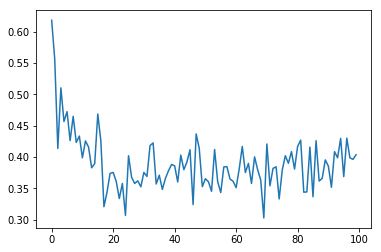

In [15]:
start = 0
plt.plot(losses[start:])

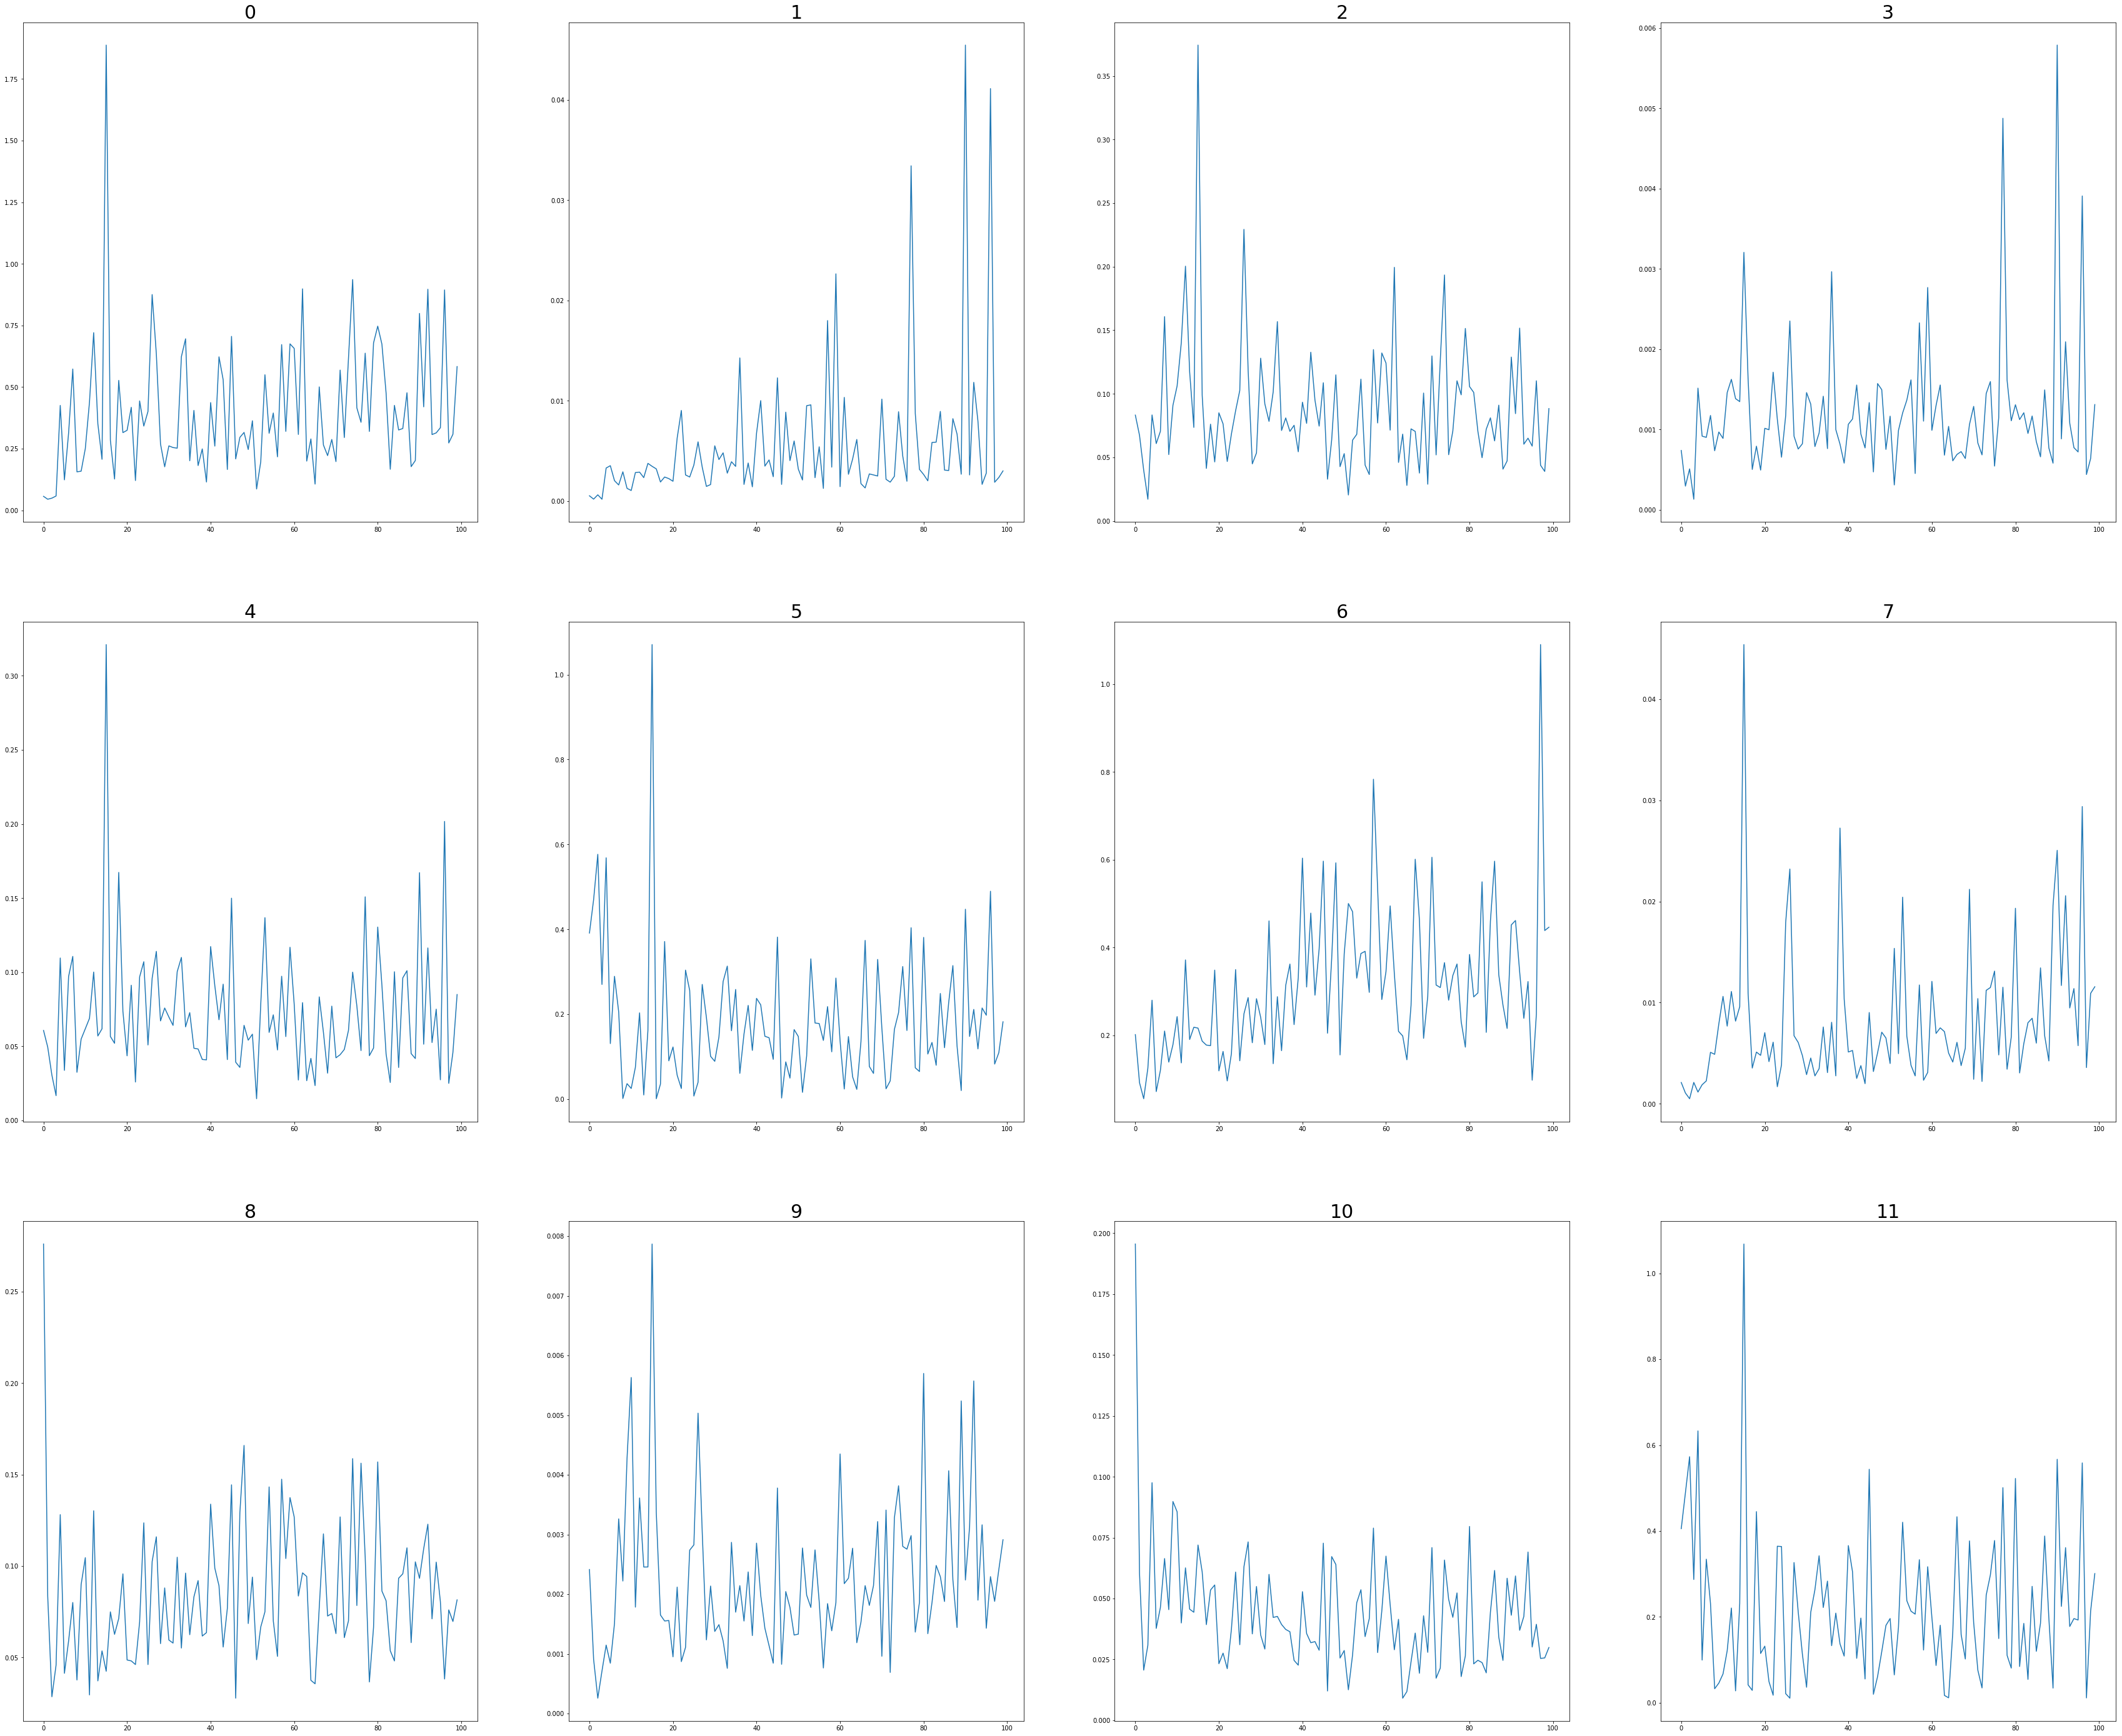

In [16]:
gradients_norms = np.array(gradients_norms)
rows = gradients_norms.shape[1]//4
cols = 4
f, arr = plt.subplots(rows, cols, figsize=(60,50))
for i in range(rows):
    for j in range(cols):
        c = cols * i + j
        arr[i,j].plot(gradients_norms[:,c])
        arr[i,j].set_title(str(c), fontsize=30)

In [17]:
# Test accuracy
z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
test_error = compute_loss(model, settings['hamiltonian'], z_samples)
print("Test error: ", test_error)

Test error:  tf.Tensor(0.36521897, shape=(), dtype=float32)


### Visualize after training

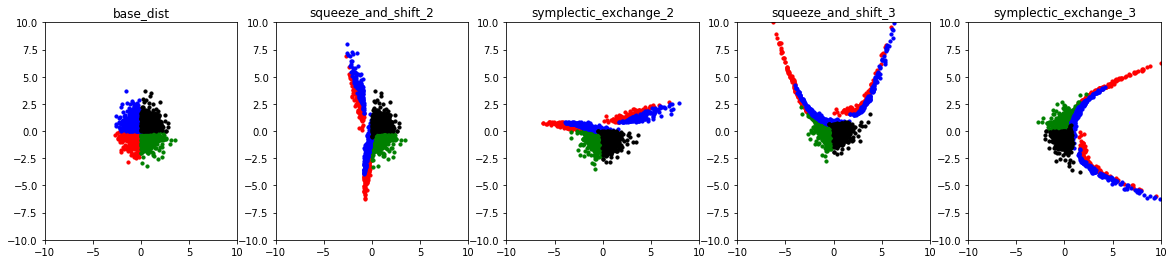

In [18]:
#z = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
z = tf.expand_dims(base_dist.sample(6*settings['batch_size']),-1)
visualize_chain_bijector_1d(model, z)

## MLP to model the derivative of the generating function

In [19]:
bijectors = [SqueezeAndShift(shift_model=MLP(return_gradient=False,activation=tf.nn.relu)) if i % 2 == 0 
             else SymplecticExchange() 
             for i in range(settings['num_bijectors'])]
model = Chain(bijectors)

### Optimize loss

In [20]:
import time
start_time = time.time()

optimizer = tf.train.AdamOptimizer(1e-4)

# TODO: implement early stopping?

global_step = []
losses = []
gradients_norms = []
for epoch in range(int(1e4)):
    z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
    gradients, loss = compute_gradients(model, settings['hamiltonian'], z_samples)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    # Visualization
    if epoch % 1e2 == 0:
        global_step.append(epoch)
        losses.append(loss.numpy())
        gradients_norms.append([tf.norm(gradients[i]).numpy() for i in range(len(gradients))])        
    if epoch % int(1e4) == 0:
        print(epoch, loss.numpy())
end_time = time.time()
print("Time elapsed: ", end_time - start_time)

0 0.6114266
Time elapsed:  138.74763250350952


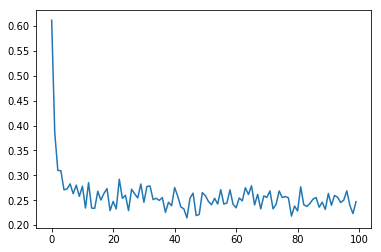

In [21]:
start = 0
plt.plot(losses[start:])

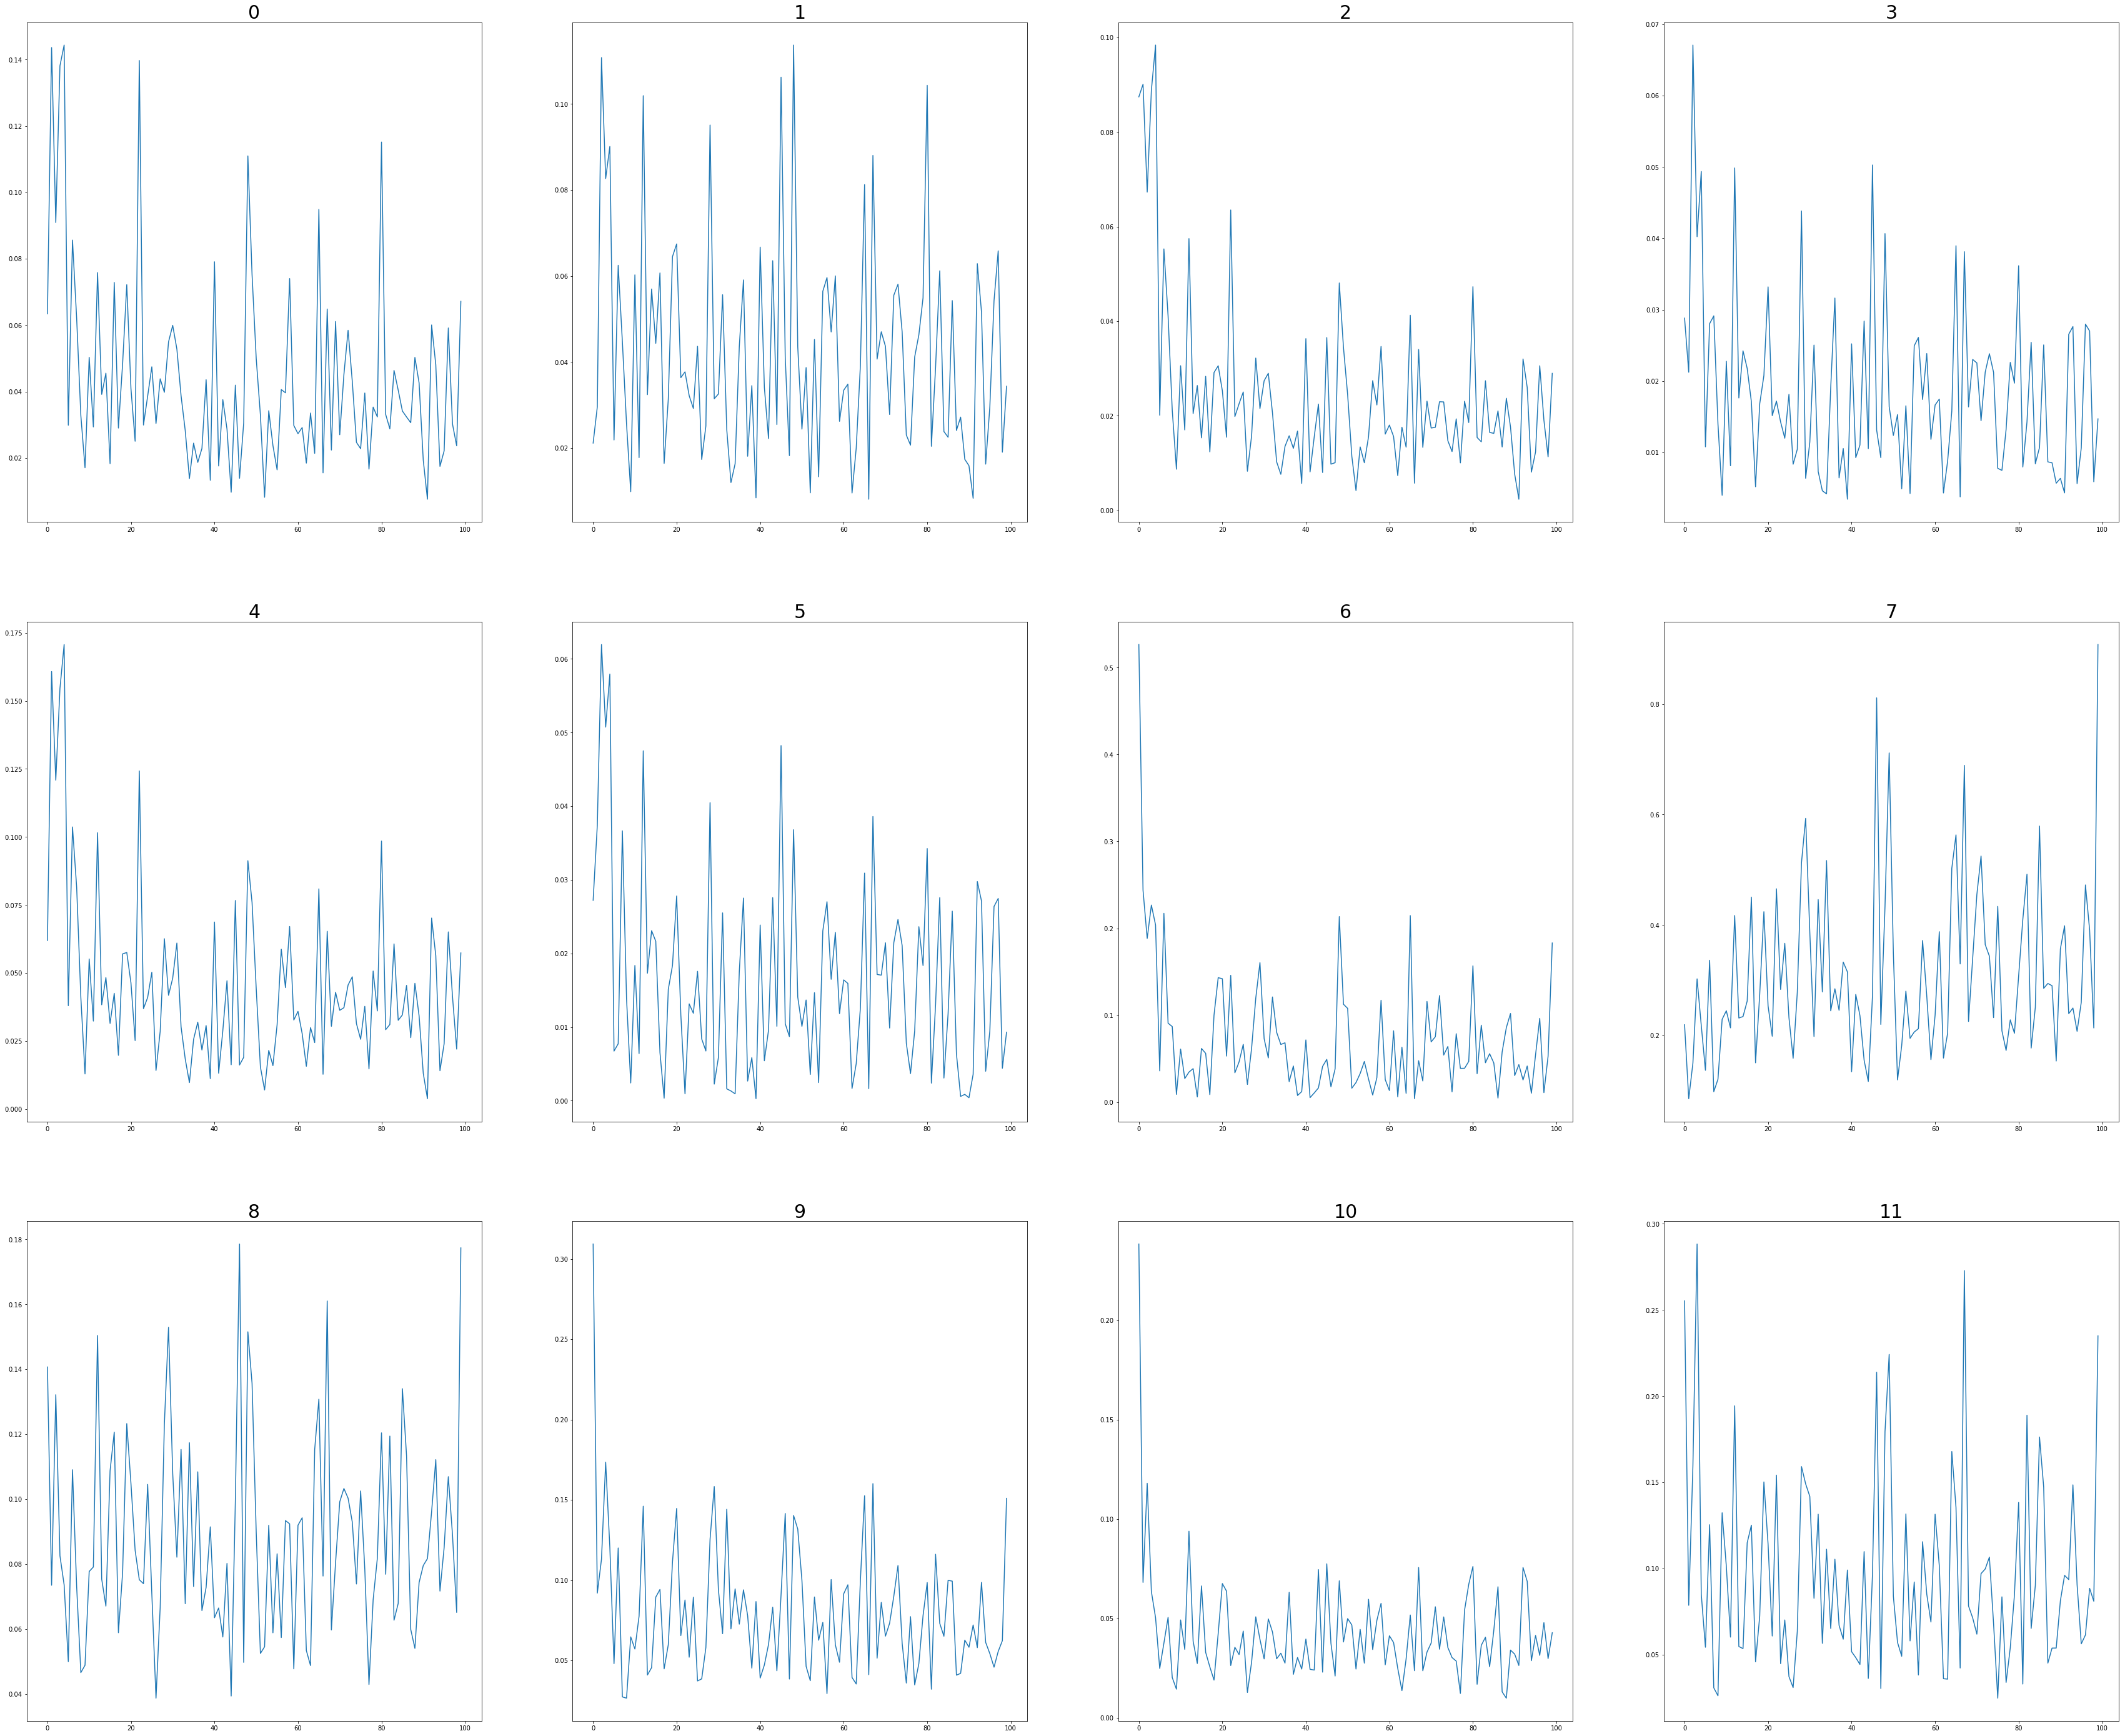

In [22]:
gradients_norms = np.array(gradients_norms)
rows = gradients_norms.shape[1]//4
cols = 4
f, arr = plt.subplots(rows, cols, figsize=(60,50))
for i in range(rows):
    for j in range(cols):
        c = cols * i + j
        arr[i,j].plot(gradients_norms[:,c])
        arr[i,j].set_title(str(c), fontsize=30)

In [23]:
# Test accuracy
z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
test_error = compute_loss(model, settings['hamiltonian'], z_samples)
print("Test error: ", test_error)

Test error:  tf.Tensor(0.24426836, shape=(), dtype=float32)


## Visualize after training

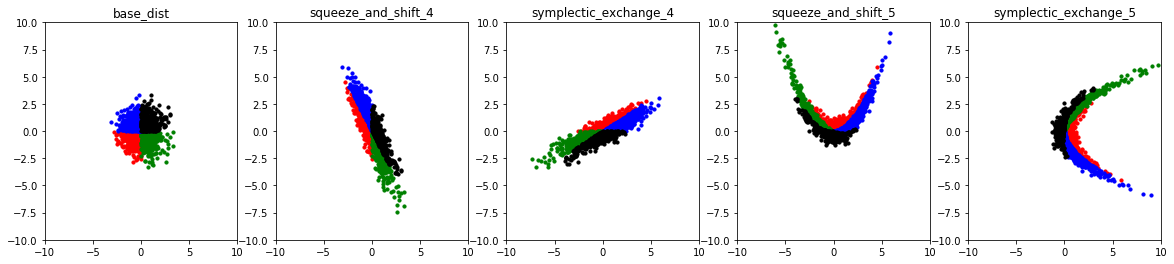

In [24]:
#z = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
z = tf.expand_dims(base_dist.sample(6*settings['batch_size']),-1)
visualize_chain_bijector_1d(model, z)

## Conclusions
In 1d, it is better to use MLP to model the derivative of the generating function rather than the generating function. In particular, if one has a non-linearity whose derivative is piecewise linear, the gradient of the MLP will be simply x-independent and with no bias. (We could tweak things such that the gradient of an MLP is an MLP and then we would have the same results.) Having a squeeze bijector helps. 

## Flow of the system

Position and momentat at time $t$, given initial condition $x_0$:

$$\varphi_t(x_0) = T \circ (\sqrt{2 E} \sin(t + \alpha), \sqrt{2 E} \cos(t + \alpha) ) \, .$$

with

$$  \tan(\alpha) = \frac{q_0}{p_0} \, ,\quad \sqrt{2E} = \frac{q_0}{\sin(\alpha)}\, ,\quad (q_0,p_0) = T^{-1} \circ x_0 \,.$$

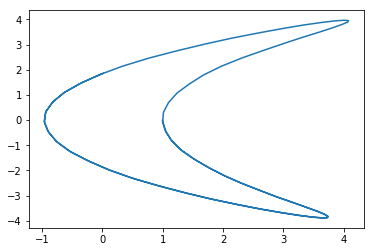

In [59]:
from utils import system_flow
    
# Initial conditions
Q_0 = 1.
P_0 = 0
ts = np.arange(0,10,.1, dtype=NP_DTYPE)
points = system_flow(Q_0, P_0, model, ts).numpy()
qs = points[:,0,0]
ps = points[:,1,0]
plt.plot(qs,ps)

Flow is area-preserving. Here show flow of the circle:

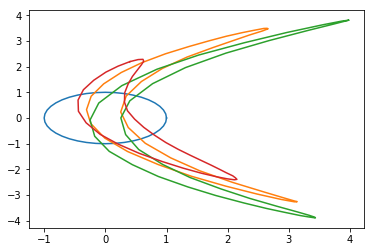

In [47]:
delta = np.pi/20
theta = np.arange(0,2*np.pi+delta, delta, dtype=NP_DTYPE)
circle = np.stack([np.cos(theta), np.sin(theta)], axis=0)
plt.plot(circle[0], circle[1])

ts = np.array([1, 5, 10], dtype=NP_DTYPE)
qs = []
ps = []
for i in range(circle.shape[1]):
    Q = circle[0][i]
    P = circle[1][i]
    points = system_flow(Q, P, model, ts).numpy()
    qs.append(points[:,0,0])
    ps.append(points[:,1,0])
plt.plot(qs,ps)

### Compare with numerical solution of Hamilton's equations

In [55]:
def f(q,p):
    """- d H / d q = - q + \tfrac{1}{4} p ^2"""
    return -q + 1/4 * p**2

def g(q,p):
    """d H / d p = - \tfrac{1}{2} q p + \tfrac{1}{16} p(1 + 2 p^2)"""
    return -1/2 * p * q + 1/16 * p * (1 + 2 * p**2)

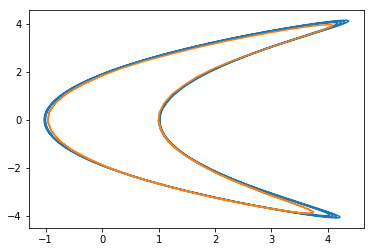

In [61]:
from utils import euler

N = 10000 # Number of time steps
h = 0.01 # size of time step
qsol, psol = euler(Q_0, P_0, f, g, N, h)
# Plot against qs ps from bijector solution
plt.plot(qsol, psol)
plt.plot(qs, ps)

This is quantitatively in agreement with the behavior obtained from the normalizing flow approach. 

TODO: Small discrepancies go away if we use a better integrator like stormer verlet than euler or train for more time?